In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt   

In [2]:
data_dir='C:/Users/hs/A_05_Part_02_Dataset'

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize([224,224]),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize([256,256]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test1', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,num_workers=4,drop_last=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True,num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [4]:
print(train_data.class_to_idx)

{'covid-19': 0, 'normal': 1, 'pneumonia': 2}


In [5]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
# print(resnet18)
# print('Output Layer of VGG16 : ', vgg18.classifier[6].out_features) # 1000 

In [6]:
num_features = resnet18.fc.in_features
print(resnet18.fc)

fc =  nn.Sequential(nn.Linear(num_features,280),nn.Sigmoid(),nn.Linear(280,3))
resnet18.fc=fc
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=512, out_features=280, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=280, out_features=3, bias=True)
)


In [7]:
class FLoss(nn.Module):
    def __init__(self,alpha=1,gamma=2):
        super(FLoss,self).__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,inputs,targets):
        loss=F.binary_cross_entropy_with_logits(inputs,targets,reduce=False)
        pt=torch.exp(-loss)
        FL=self.alpha*(1-pt)**self.gamma*loss
        
        return torch.mean(FL)

In [8]:
Epochs = 1
criterion =FLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [9]:
from tqdm import tqdm
y=torch.zeros(32,3)
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
#     print(type(trainloader))

    pbar = tqdm(enumerate(trainloader))
#     print(pbar)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        x=list(labels.shape)
        for j in range(x[0]):
            if(labels[j]==0):
                y[j,0]=1
                y[j,1]=0
                y[j,2]=1
            if(labels[j]==1):
                y[j,0]=0
                y[j,1]=1
                y[j,2]=0
            if(labels[j]==2):
                y[j,0]=0
                y[j,1]=0
                y[j,2]=1
                
        inputs, labels = inputs.to(device), y.to(device)
#         print(len(inputs))
#         print(len(y))
#         print(i)
        # zero the parameter gradients
        
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs) #----> forward pass
#         print(outputs.shape)
#         print(y.shape)
        loss = criterion(outputs, y)#----> compute loss
#         print(type(loss))
#         print(loss.shape)
#         print(loss)
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        
        # print statistics
        running_loss += loss.item()
#         print(loss.item())
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'Resnet18_full.pth')

print('Finished Training')

0it [00:00, ?it/s]C:\Users\hs\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


<class 'torch.Tensor'>
torch.Size([])
tensor(0.1531, grad_fn=<MeanBackward0>)


Train Epoch: 0 [0/6200 (0%)]	Loss: 0.153089: : 1it [00:11, 11.82s/it]

<class 'torch.Tensor'>
torch.Size([])
tensor(0.1600, grad_fn=<MeanBackward0>)


Train Epoch: 0 [32/6200 (1%)]	Loss: 0.159982: : 2it [00:20, 10.97s/it]

KeyboardInterrupt: 

In [95]:
correct = 0
total = 0
actualclasses=[]
predictedclasses=[]

with torch.no_grad():
    for data in testloader:
        images, labels = data
        actualclasses.append(labels.tolist())
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        predictedclasses.append(predicted.tolist())
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


In [ ]:
correct = 0
total = 0
actualclassesv=[]
predictedclassesv=[]


with torch.no_grad():
    for data in validationloader:
        images, labels = data
        actualclassesv.append(labels.tolist())
        images, labels = images.to(device), labels.to(device)
        outputs = loadedmodel(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         print('Prediction are Coming')
#         print(predicted)
        predictedclassesv.append(predicted.tolist())
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
correct = 0
total = 0
actualclassest=[]
predictedclassest=[]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        actualclassest.append(labels.tolist())
        images, labels = images.to(device), labels.to(device)
        outputs = loadedmodel(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         print('Prediction are Coming')
#         print(predicted)
        predictedclassest.append(predicted.tolist())
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
loadedmodel=models.resnet18(pretrained=False)

In [ ]:
num_features = loadedmodel.fc.in_features
print(loadedmodel.fc)

fc =  nn.Sequential(nn.Linear(num_features,280),nn.Sigmoid(),nn.Linear(280,3))
loadedmodel.fc=fc
print(loadedmodel.fc)

In [ ]:
loadedmodel.load_state_dict(torch.load('Resnet18_.pth'))
loadedmodel.eval()

47
47
32
32
Confusion Matrix :
[[560  55]
 [ 33 852]]


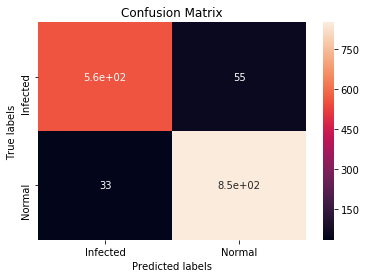

In [118]:
# actual=[item for sub in actualclasses for item in sub]
# prediction=[item for sub in predictedclasses for item in sub]

actualt=[item for sub in actualclassest for item in sub]
predictiont=[item for sub in predictedclassest for item in sub]

actualv=[item for sub in actualclassesv for item in sub]
predictionv=[item for sub in predictedclassesv for item in sub]

cm=confusion_matrix(actualt,predictiont)
ax=plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Covid','Normal','Pneumia'])
ax.yaxis.set_ticklabels(['Covid','Normal','Pneumia'])

print('Accuracy_score:',accuracy_score(actualt,predictiont))
print('Report:')
print(classification_report(actualt,predictiont))



In [ ]:
correct = 0
total = 0
# actualclasses=[]
predictedclasses=[]

with torch.no_grad():
    for data in testloader:
        images, labels = data
#         actualclasses.append(labels.tolist())
        images, labels = images.to(device), labels.to(device)
        outputs = loadedmodel(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         print('Prediction are Coming')
#         print(predicted)
        predictedclasses.append(predicted.tolist())
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

In [ ]:
prediction=[item for sub in predictedclasses for item in sub]
one_hotp=np.zeros((len(prediction),3))
for j in range(len(prediction)):
    if(prediction[j]==0):
        one_hotp[j,0]=1
        one_hotp[j,1]=1
        one_hotp[j,2]=0
    if(prediction[j]==1):
        one_hotp[j,0]=0
        one_hotp[j,1]=0
        one_hotp[j,2]=1
    if(prediction[j]==2):
        one_hotp[j,0]=0
        one_hotp[j,1]=1
        one_hotp[j,2]=0

In [ ]:
print(one_hotp)
with open('vggBCE.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for  i in range (one_hotp.shape[0]):
        writer.writerow([i,one_hotp[i,0],one_hotp[i,1],one_hotp[i,2]])